In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from deep_emotion import Deep_Emotion

# Paths
DATASET_DIR = "/content/"
CSV_FILE = os.path.join(DATASET_DIR, "fer2013.csv")
OUTPUT_DIR = "dataset/"

# Convert FER-2013 CSV to images
def convert_csv_to_images():
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    data = pd.read_csv(CSV_FILE)
    usage_mapping = {"Training": "train", "PublicTest": "val", "PrivateTest": "test"}

    for index, row in tqdm(data.iterrows(), total=len(data)):
        pixels = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        img = Image.fromarray(pixels)
        label = row['emotion']
        usage = usage_mapping[row['Usage']]
        label_dir = os.path.join(OUTPUT_DIR, usage, str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        img.save(os.path.join(label_dir, f"{index}.jpg"))
    print("Dataset conversion complete.")

# Define Dataset class
class FERDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(img_dir):
            label_path = os.path.join(img_dir, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Load dataset
def load_data():
    transformation = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = FERDataset(os.path.join(OUTPUT_DIR, "train"), transform=transformation)
    val_dataset = FERDataset(os.path.join(OUTPUT_DIR, "val"), transform=transformation)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    return train_loader, val_loader



In [ ]:
MODEL_PATH = "best_model1.pth"
PICS_FOLDER = "pics/"

def early_stopping(val_loss, val_acc, patience, min_delta, counter, best_loss, best_acc, epoch):
    if epoch < 150:
        return counter, best_loss, best_acc, False  # Don't stop before 150 epochs

    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        best_acc = val_acc
        counter = 0
    elif val_acc > best_acc:
        best_acc = val_acc
        counter = 0
    else:
        counter += 1
    return counter, best_loss, best_acc, counter >= patience

# Improve model training with data augmentation and deeper network
def get_transforms():
    return transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

# Train model with improved architecture and learning techniques
def train_model(model, train_loader, val_loader, epochs=200, lr=0.001, patience=20, min_delta=0.0005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    best_loss = float("inf")
    best_acc = 0.0
    counter = 0

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_correct/len(train_loader.dataset):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

        # Save best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"Best model saved with Val Acc: {best_acc:.4f}")

        # Early stopping check
        counter, best_loss, best_acc, stop = early_stopping(val_loss, val_acc, patience, min_delta, counter, best_loss, best_acc, epoch+1)
        if stop:
            print("Early stopping triggered. Training stopped.")
            break

    print(f"Final best model saved with Val Acc: {best_acc:.4f}")

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Model training complete and saved as {MODEL_PATH}")


if __name__ == "__main__":
    convert_csv_to_images()
    train_loader, val_loader = load_data()
    model = Deep_Emotion()
    train_model(model, train_loader, val_loader)


100%|██████████| 35887/35887 [00:24<00:00, 1457.98it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Dataset conversion complete.


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4969: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Training Progress:   0%|          | 1/500 [00:15<2:10:46, 15.73s/it]

Epoch 1/500, Train Loss: 1.6814, Train Acc: 0.3260, Val Loss: 1.5790, Val Acc: 0.3979
Best model saved with Val Acc: 0.3979


Training Progress:   0%|          | 2/500 [00:31<2:10:23, 15.71s/it]

Epoch 2/500, Train Loss: 1.5410, Train Acc: 0.4001, Val Loss: 1.5163, Val Acc: 0.4185
Best model saved with Val Acc: 0.4185


Training Progress:   1%|          | 3/500 [00:48<2:14:47, 16.27s/it]

Epoch 3/500, Train Loss: 1.4668, Train Acc: 0.4305, Val Loss: 1.4621, Val Acc: 0.4405
Best model saved with Val Acc: 0.4405


Training Progress:   1%|          | 4/500 [01:04<2:15:20, 16.37s/it]

Epoch 4/500, Train Loss: 1.4105, Train Acc: 0.4557, Val Loss: 1.4297, Val Acc: 0.4558
Best model saved with Val Acc: 0.4558


Training Progress:   1%|          | 5/500 [01:21<2:16:40, 16.57s/it]

Epoch 5/500, Train Loss: 1.3806, Train Acc: 0.4668, Val Loss: 1.4162, Val Acc: 0.4575
Best model saved with Val Acc: 0.4575


Training Progress:   1%|          | 6/500 [01:37<2:15:15, 16.43s/it]

Epoch 6/500, Train Loss: 1.3516, Train Acc: 0.4782, Val Loss: 1.3987, Val Acc: 0.4609
Best model saved with Val Acc: 0.4609


Training Progress:   1%|▏         | 7/500 [01:54<2:14:18, 16.34s/it]

Epoch 7/500, Train Loss: 1.3241, Train Acc: 0.4905, Val Loss: 1.4075, Val Acc: 0.4664
Best model saved with Val Acc: 0.4664


Training Progress:   2%|▏         | 8/500 [02:10<2:13:01, 16.22s/it]

Epoch 8/500, Train Loss: 1.3096, Train Acc: 0.4961, Val Loss: 1.3737, Val Acc: 0.4723
Best model saved with Val Acc: 0.4723


Training Progress:   2%|▏         | 9/500 [02:26<2:14:19, 16.41s/it]

Epoch 9/500, Train Loss: 1.2888, Train Acc: 0.5060, Val Loss: 1.3701, Val Acc: 0.4935
Best model saved with Val Acc: 0.4935


Training Progress:   2%|▏         | 10/500 [02:43<2:14:22, 16.45s/it]

Epoch 10/500, Train Loss: 1.2720, Train Acc: 0.5135, Val Loss: 1.3547, Val Acc: 0.4940
Best model saved with Val Acc: 0.4940


Training Progress:   2%|▏         | 11/500 [02:59<2:13:23, 16.37s/it]

Epoch 11/500, Train Loss: 1.2635, Train Acc: 0.5148, Val Loss: 1.3597, Val Acc: 0.4929


Training Progress:   2%|▏         | 12/500 [03:15<2:12:13, 16.26s/it]

Epoch 12/500, Train Loss: 1.2507, Train Acc: 0.5189, Val Loss: 1.3478, Val Acc: 0.5032
Best model saved with Val Acc: 0.5032


Training Progress:   3%|▎         | 13/500 [03:31<2:11:13, 16.17s/it]

Epoch 13/500, Train Loss: 1.2385, Train Acc: 0.5219, Val Loss: 1.3488, Val Acc: 0.5021


Training Progress:   3%|▎         | 14/500 [03:47<2:11:29, 16.23s/it]

Epoch 14/500, Train Loss: 1.2296, Train Acc: 0.5303, Val Loss: 1.3255, Val Acc: 0.5029


Training Progress:   3%|▎         | 15/500 [04:04<2:10:58, 16.20s/it]

Epoch 15/500, Train Loss: 1.2248, Train Acc: 0.5290, Val Loss: 1.3072, Val Acc: 0.5124
Best model saved with Val Acc: 0.5124


Training Progress:   3%|▎         | 16/500 [04:20<2:10:08, 16.13s/it]

Epoch 16/500, Train Loss: 1.2127, Train Acc: 0.5364, Val Loss: 1.3456, Val Acc: 0.4962


Training Progress:   3%|▎         | 17/500 [04:35<2:09:16, 16.06s/it]

Epoch 17/500, Train Loss: 1.2042, Train Acc: 0.5412, Val Loss: 1.2964, Val Acc: 0.5116


Training Progress:   4%|▎         | 18/500 [04:51<2:08:32, 16.00s/it]

Epoch 18/500, Train Loss: 1.1968, Train Acc: 0.5455, Val Loss: 1.3061, Val Acc: 0.5130
Best model saved with Val Acc: 0.5130


Training Progress:   4%|▍         | 19/500 [05:08<2:09:11, 16.12s/it]

Epoch 19/500, Train Loss: 1.1919, Train Acc: 0.5410, Val Loss: 1.2863, Val Acc: 0.5183
Best model saved with Val Acc: 0.5183


Training Progress:   4%|▍         | 20/500 [05:24<2:09:01, 16.13s/it]

Epoch 20/500, Train Loss: 1.1821, Train Acc: 0.5469, Val Loss: 1.3192, Val Acc: 0.5118


Training Progress:   4%|▍         | 21/500 [05:40<2:07:40, 15.99s/it]

Epoch 21/500, Train Loss: 1.1768, Train Acc: 0.5488, Val Loss: 1.2957, Val Acc: 0.5118


Training Progress:   4%|▍         | 22/500 [05:56<2:07:19, 15.98s/it]

Epoch 22/500, Train Loss: 1.1775, Train Acc: 0.5520, Val Loss: 1.3232, Val Acc: 0.5065


Training Progress:   5%|▍         | 23/500 [06:11<2:06:42, 15.94s/it]

Epoch 23/500, Train Loss: 1.1677, Train Acc: 0.5569, Val Loss: 1.3162, Val Acc: 0.5077


Training Progress:   5%|▍         | 24/500 [06:27<2:06:46, 15.98s/it]

Epoch 24/500, Train Loss: 1.1740, Train Acc: 0.5518, Val Loss: 1.2943, Val Acc: 0.5141


Training Progress:   5%|▌         | 25/500 [06:44<2:07:54, 16.16s/it]

Epoch 25/500, Train Loss: 1.1618, Train Acc: 0.5558, Val Loss: 1.2892, Val Acc: 0.5135


Training Progress:   5%|▌         | 26/500 [07:00<2:06:43, 16.04s/it]

Epoch 26/500, Train Loss: 1.1354, Train Acc: 0.5678, Val Loss: 1.2642, Val Acc: 0.5300
Best model saved with Val Acc: 0.5300


Training Progress:   5%|▌         | 27/500 [07:16<2:06:03, 15.99s/it]

Epoch 27/500, Train Loss: 1.1227, Train Acc: 0.5745, Val Loss: 1.2424, Val Acc: 0.5352
Best model saved with Val Acc: 0.5352


Training Progress:   6%|▌         | 28/500 [07:32<2:05:29, 15.95s/it]

Epoch 28/500, Train Loss: 1.1249, Train Acc: 0.5719, Val Loss: 1.2627, Val Acc: 0.5375
Best model saved with Val Acc: 0.5375


Training Progress:   6%|▌         | 29/500 [07:47<2:04:57, 15.92s/it]

Epoch 29/500, Train Loss: 1.1174, Train Acc: 0.5754, Val Loss: 1.2723, Val Acc: 0.5199


Training Progress:   6%|▌         | 30/500 [08:04<2:05:42, 16.05s/it]

Epoch 30/500, Train Loss: 1.1131, Train Acc: 0.5785, Val Loss: 1.2530, Val Acc: 0.5269


Training Progress:   6%|▌         | 31/500 [08:20<2:04:57, 15.99s/it]

Epoch 31/500, Train Loss: 1.1140, Train Acc: 0.5785, Val Loss: 1.2572, Val Acc: 0.5311


Training Progress:   6%|▋         | 32/500 [08:35<2:04:15, 15.93s/it]

Epoch 32/500, Train Loss: 1.1082, Train Acc: 0.5777, Val Loss: 1.2572, Val Acc: 0.5327


Training Progress:   7%|▋         | 33/500 [08:51<2:03:43, 15.90s/it]

Epoch 33/500, Train Loss: 1.0990, Train Acc: 0.5829, Val Loss: 1.2794, Val Acc: 0.5199


Training Progress:   7%|▋         | 34/500 [09:07<2:03:09, 15.86s/it]

Epoch 34/500, Train Loss: 1.0878, Train Acc: 0.5856, Val Loss: 1.2791, Val Acc: 0.5327


Training Progress:   7%|▋         | 35/500 [09:23<2:03:59, 16.00s/it]

Epoch 35/500, Train Loss: 1.0816, Train Acc: 0.5885, Val Loss: 1.2775, Val Acc: 0.5386
Best model saved with Val Acc: 0.5386


Training Progress:   7%|▋         | 36/500 [09:39<2:04:00, 16.04s/it]

Epoch 36/500, Train Loss: 1.0759, Train Acc: 0.5923, Val Loss: 1.2589, Val Acc: 0.5325


Training Progress:   7%|▋         | 37/500 [09:55<2:03:04, 15.95s/it]

Epoch 37/500, Train Loss: 1.0673, Train Acc: 0.5921, Val Loss: 1.2543, Val Acc: 0.5375


Training Progress:   8%|▊         | 38/500 [10:11<2:01:58, 15.84s/it]

Epoch 38/500, Train Loss: 1.0699, Train Acc: 0.5916, Val Loss: 1.2653, Val Acc: 0.5322


Training Progress:   8%|▊         | 39/500 [10:26<2:01:11, 15.77s/it]

Epoch 39/500, Train Loss: 1.0636, Train Acc: 0.5936, Val Loss: 1.2788, Val Acc: 0.5330


Training Progress:   8%|▊         | 40/500 [10:42<2:00:54, 15.77s/it]

Epoch 40/500, Train Loss: 1.0521, Train Acc: 0.6008, Val Loss: 1.2529, Val Acc: 0.5408
Best model saved with Val Acc: 0.5408


Training Progress:   8%|▊         | 41/500 [10:58<2:02:04, 15.96s/it]

Epoch 41/500, Train Loss: 1.0526, Train Acc: 0.6019, Val Loss: 1.2700, Val Acc: 0.5400


Training Progress:   8%|▊         | 42/500 [11:14<2:01:02, 15.86s/it]

Epoch 42/500, Train Loss: 1.0501, Train Acc: 0.6001, Val Loss: 1.2513, Val Acc: 0.5425
Best model saved with Val Acc: 0.5425


Training Progress:   9%|▊         | 43/500 [11:30<1:59:51, 15.74s/it]

Epoch 43/500, Train Loss: 1.0516, Train Acc: 0.6013, Val Loss: 1.2507, Val Acc: 0.5400


Training Progress:   9%|▉         | 44/500 [11:45<1:59:24, 15.71s/it]

Epoch 44/500, Train Loss: 1.0463, Train Acc: 0.6005, Val Loss: 1.2599, Val Acc: 0.5294


Training Progress:   9%|▉         | 45/500 [12:01<1:59:06, 15.71s/it]

Epoch 45/500, Train Loss: 1.0490, Train Acc: 0.6003, Val Loss: 1.2750, Val Acc: 0.5408


Training Progress:   9%|▉         | 46/500 [12:17<1:59:20, 15.77s/it]

Epoch 46/500, Train Loss: 1.0394, Train Acc: 0.6058, Val Loss: 1.2706, Val Acc: 0.5389


Training Progress:   9%|▉         | 47/500 [12:33<2:00:31, 15.96s/it]

Epoch 47/500, Train Loss: 1.0432, Train Acc: 0.6025, Val Loss: 1.2734, Val Acc: 0.5380


Training Progress:  10%|▉         | 48/500 [12:49<1:59:34, 15.87s/it]

Epoch 48/500, Train Loss: 1.0358, Train Acc: 0.6091, Val Loss: 1.2703, Val Acc: 0.5355


Training Progress:  10%|▉         | 49/500 [13:05<1:59:06, 15.85s/it]

Epoch 49/500, Train Loss: 1.0393, Train Acc: 0.6064, Val Loss: 1.2448, Val Acc: 0.5408


Training Progress:  10%|█         | 50/500 [13:20<1:58:35, 15.81s/it]

Epoch 50/500, Train Loss: 1.0296, Train Acc: 0.6120, Val Loss: 1.2670, Val Acc: 0.5322


Training Progress:  10%|█         | 51/500 [13:36<1:58:02, 15.77s/it]

Epoch 51/500, Train Loss: 1.0320, Train Acc: 0.6116, Val Loss: 1.2562, Val Acc: 0.5403


Training Progress:  10%|█         | 52/500 [13:53<1:59:34, 16.01s/it]

Epoch 52/500, Train Loss: 1.0272, Train Acc: 0.6096, Val Loss: 1.2557, Val Acc: 0.5383


Training Progress:  11%|█         | 53/500 [14:09<1:59:01, 15.98s/it]

Epoch 53/500, Train Loss: 1.0308, Train Acc: 0.6075, Val Loss: 1.2689, Val Acc: 0.5495
Best model saved with Val Acc: 0.5495


Training Progress:  11%|█         | 54/500 [14:24<1:58:05, 15.89s/it]

Epoch 54/500, Train Loss: 1.0274, Train Acc: 0.6096, Val Loss: 1.2765, Val Acc: 0.5333


Training Progress:  11%|█         | 55/500 [14:40<1:57:30, 15.84s/it]

Epoch 55/500, Train Loss: 1.0239, Train Acc: 0.6137, Val Loss: 1.2816, Val Acc: 0.5400


Training Progress:  11%|█         | 56/500 [14:56<1:57:07, 15.83s/it]

Epoch 56/500, Train Loss: 1.0236, Train Acc: 0.6119, Val Loss: 1.2783, Val Acc: 0.5391


Training Progress:  11%|█▏        | 57/500 [15:12<1:57:36, 15.93s/it]

Epoch 57/500, Train Loss: 1.0218, Train Acc: 0.6150, Val Loss: 1.2795, Val Acc: 0.5339


Training Progress:  12%|█▏        | 58/500 [15:28<1:57:41, 15.98s/it]

Epoch 58/500, Train Loss: 1.0168, Train Acc: 0.6156, Val Loss: 1.2533, Val Acc: 0.5372


Training Progress:  12%|█▏        | 59/500 [15:44<1:57:05, 15.93s/it]

Epoch 59/500, Train Loss: 1.0292, Train Acc: 0.6096, Val Loss: 1.2631, Val Acc: 0.5386


Training Progress:  12%|█▏        | 60/500 [16:00<1:56:19, 15.86s/it]

Epoch 60/500, Train Loss: 1.0236, Train Acc: 0.6132, Val Loss: 1.2631, Val Acc: 0.5378


Training Progress:  12%|█▏        | 61/500 [16:15<1:56:07, 15.87s/it]

Epoch 61/500, Train Loss: 1.0257, Train Acc: 0.6106, Val Loss: 1.2711, Val Acc: 0.5386


Training Progress:  12%|█▏        | 62/500 [16:32<1:56:19, 15.94s/it]

Epoch 62/500, Train Loss: 1.0236, Train Acc: 0.6099, Val Loss: 1.2628, Val Acc: 0.5322


Training Progress:  13%|█▎        | 63/500 [16:48<1:57:03, 16.07s/it]

Epoch 63/500, Train Loss: 1.0183, Train Acc: 0.6152, Val Loss: 1.2488, Val Acc: 0.5391


Training Progress:  13%|█▎        | 64/500 [17:04<1:56:02, 15.97s/it]

Epoch 64/500, Train Loss: 1.0227, Train Acc: 0.6119, Val Loss: 1.2768, Val Acc: 0.5330


Training Progress:  13%|█▎        | 65/500 [17:19<1:54:51, 15.84s/it]

Epoch 65/500, Train Loss: 1.0237, Train Acc: 0.6110, Val Loss: 1.2456, Val Acc: 0.5336


Training Progress:  13%|█▎        | 66/500 [17:35<1:54:24, 15.82s/it]

Epoch 66/500, Train Loss: 1.0214, Train Acc: 0.6109, Val Loss: 1.2459, Val Acc: 0.5517
Best model saved with Val Acc: 0.5517


Training Progress:  13%|█▎        | 67/500 [17:51<1:54:20, 15.84s/it]

Epoch 67/500, Train Loss: 1.0194, Train Acc: 0.6145, Val Loss: 1.2539, Val Acc: 0.5414


Training Progress:  14%|█▎        | 68/500 [18:07<1:55:08, 15.99s/it]

Epoch 68/500, Train Loss: 1.0205, Train Acc: 0.6150, Val Loss: 1.2377, Val Acc: 0.5411


Training Progress:  14%|█▍        | 69/500 [18:23<1:54:23, 15.93s/it]

Epoch 69/500, Train Loss: 1.0181, Train Acc: 0.6143, Val Loss: 1.2900, Val Acc: 0.5330


Training Progress:  14%|█▍        | 70/500 [18:39<1:53:46, 15.88s/it]

Epoch 70/500, Train Loss: 1.0234, Train Acc: 0.6116, Val Loss: 1.2321, Val Acc: 0.5417


Training Progress:  14%|█▍        | 71/500 [18:54<1:53:10, 15.83s/it]

Epoch 71/500, Train Loss: 1.0232, Train Acc: 0.6111, Val Loss: 1.2629, Val Acc: 0.5444


Training Progress:  14%|█▍        | 72/500 [19:10<1:52:49, 15.82s/it]

Epoch 72/500, Train Loss: 1.0203, Train Acc: 0.6147, Val Loss: 1.2576, Val Acc: 0.5350


Training Progress:  15%|█▍        | 73/500 [19:26<1:52:29, 15.81s/it]

Epoch 73/500, Train Loss: 1.0228, Train Acc: 0.6100, Val Loss: 1.2650, Val Acc: 0.5358


Training Progress:  15%|█▍        | 74/500 [19:42<1:53:18, 15.96s/it]

Epoch 74/500, Train Loss: 1.0234, Train Acc: 0.6132, Val Loss: 1.2638, Val Acc: 0.5433


Training Progress:  15%|█▌        | 75/500 [19:58<1:52:30, 15.88s/it]

Epoch 75/500, Train Loss: 1.0208, Train Acc: 0.6131, Val Loss: 1.2448, Val Acc: 0.5453


Training Progress:  15%|█▌        | 76/500 [20:14<1:51:33, 15.79s/it]

Epoch 76/500, Train Loss: 1.0197, Train Acc: 0.6127, Val Loss: 1.2487, Val Acc: 0.5428


Training Progress:  15%|█▌        | 77/500 [20:29<1:50:58, 15.74s/it]

Epoch 77/500, Train Loss: 1.0211, Train Acc: 0.6134, Val Loss: 1.2669, Val Acc: 0.5444


Training Progress:  16%|█▌        | 78/500 [20:45<1:51:43, 15.88s/it]

Epoch 78/500, Train Loss: 1.0169, Train Acc: 0.6148, Val Loss: 1.2805, Val Acc: 0.5391


Training Progress:  16%|█▌        | 79/500 [21:02<1:52:53, 16.09s/it]

Epoch 79/500, Train Loss: 1.0136, Train Acc: 0.6162, Val Loss: 1.2547, Val Acc: 0.5394


Training Progress:  16%|█▌        | 80/500 [21:18<1:52:26, 16.06s/it]

Epoch 80/500, Train Loss: 1.0204, Train Acc: 0.6127, Val Loss: 1.2550, Val Acc: 0.5428


Training Progress:  16%|█▌        | 81/500 [21:34<1:51:48, 16.01s/it]

Epoch 81/500, Train Loss: 1.0189, Train Acc: 0.6149, Val Loss: 1.2503, Val Acc: 0.5397


Training Progress:  16%|█▋        | 82/500 [21:50<1:50:53, 15.92s/it]

Epoch 82/500, Train Loss: 1.0161, Train Acc: 0.6150, Val Loss: 1.2722, Val Acc: 0.5405


Training Progress:  17%|█▋        | 83/500 [22:05<1:50:12, 15.86s/it]

Epoch 83/500, Train Loss: 1.0191, Train Acc: 0.6142, Val Loss: 1.2548, Val Acc: 0.5405


Training Progress:  17%|█▋        | 84/500 [22:22<1:51:09, 16.03s/it]

Epoch 84/500, Train Loss: 1.0142, Train Acc: 0.6124, Val Loss: 1.2625, Val Acc: 0.5428


Training Progress:  17%|█▋        | 85/500 [22:38<1:51:47, 16.16s/it]

Epoch 85/500, Train Loss: 1.0180, Train Acc: 0.6171, Val Loss: 1.2810, Val Acc: 0.5327


Training Progress:  17%|█▋        | 86/500 [22:54<1:50:47, 16.06s/it]

Epoch 86/500, Train Loss: 1.0178, Train Acc: 0.6149, Val Loss: 1.2693, Val Acc: 0.5369


Training Progress:  17%|█▋        | 87/500 [23:10<1:50:08, 16.00s/it]

Epoch 87/500, Train Loss: 1.0139, Train Acc: 0.6166, Val Loss: 1.2656, Val Acc: 0.5350


Training Progress:  18%|█▊        | 88/500 [23:26<1:49:26, 15.94s/it]

Epoch 88/500, Train Loss: 1.0183, Train Acc: 0.6145, Val Loss: 1.2470, Val Acc: 0.5389


Training Progress:  18%|█▊        | 89/500 [23:42<1:49:05, 15.93s/it]

Epoch 89/500, Train Loss: 1.0170, Train Acc: 0.6160, Val Loss: 1.2456, Val Acc: 0.5378


Training Progress:  18%|█▊        | 90/500 [23:58<1:49:56, 16.09s/it]

Epoch 90/500, Train Loss: 1.0126, Train Acc: 0.6171, Val Loss: 1.2606, Val Acc: 0.5400


Training Progress:  18%|█▊        | 91/500 [24:14<1:49:39, 16.09s/it]

Epoch 91/500, Train Loss: 1.0168, Train Acc: 0.6167, Val Loss: 1.2606, Val Acc: 0.5386


Training Progress:  18%|█▊        | 92/500 [24:30<1:48:49, 16.00s/it]

Epoch 92/500, Train Loss: 1.0203, Train Acc: 0.6124, Val Loss: 1.2589, Val Acc: 0.5469


Training Progress:  19%|█▊        | 93/500 [24:46<1:48:14, 15.96s/it]

Epoch 93/500, Train Loss: 1.0219, Train Acc: 0.6129, Val Loss: 1.2574, Val Acc: 0.5425


Training Progress:  19%|█▉        | 94/500 [25:02<1:47:41, 15.91s/it]

Epoch 94/500, Train Loss: 1.0171, Train Acc: 0.6156, Val Loss: 1.2537, Val Acc: 0.5456


Training Progress:  19%|█▉        | 95/500 [25:18<1:49:11, 16.18s/it]

Epoch 95/500, Train Loss: 1.0201, Train Acc: 0.6124, Val Loss: 1.2593, Val Acc: 0.5430


Training Progress:  19%|█▉        | 96/500 [25:34<1:48:14, 16.08s/it]

Epoch 96/500, Train Loss: 1.0171, Train Acc: 0.6143, Val Loss: 1.2428, Val Acc: 0.5389


Training Progress:  19%|█▉        | 97/500 [25:50<1:47:10, 15.96s/it]

Epoch 97/500, Train Loss: 1.0204, Train Acc: 0.6129, Val Loss: 1.2738, Val Acc: 0.5344


Training Progress:  20%|█▉        | 98/500 [26:06<1:46:34, 15.91s/it]

Epoch 98/500, Train Loss: 1.0204, Train Acc: 0.6158, Val Loss: 1.2671, Val Acc: 0.5389


Training Progress:  20%|█▉        | 99/500 [26:21<1:45:46, 15.83s/it]

Epoch 99/500, Train Loss: 1.0185, Train Acc: 0.6128, Val Loss: 1.2667, Val Acc: 0.5408


Training Progress:  20%|██        | 100/500 [26:38<1:46:12, 15.93s/it]

Epoch 100/500, Train Loss: 1.0135, Train Acc: 0.6183, Val Loss: 1.2507, Val Acc: 0.5378


Training Progress:  20%|██        | 101/500 [26:54<1:46:17, 15.98s/it]

Epoch 101/500, Train Loss: 1.0188, Train Acc: 0.6140, Val Loss: 1.2577, Val Acc: 0.5495


Training Progress:  20%|██        | 102/500 [27:10<1:45:46, 15.95s/it]

Epoch 102/500, Train Loss: 1.0182, Train Acc: 0.6184, Val Loss: 1.2617, Val Acc: 0.5352


Training Progress:  21%|██        | 103/500 [27:25<1:45:06, 15.89s/it]

Epoch 103/500, Train Loss: 1.0196, Train Acc: 0.6147, Val Loss: 1.2663, Val Acc: 0.5464


Training Progress:  21%|██        | 104/500 [27:41<1:45:09, 15.93s/it]

Epoch 104/500, Train Loss: 1.0214, Train Acc: 0.6128, Val Loss: 1.2524, Val Acc: 0.5450


Training Progress:  21%|██        | 105/500 [27:57<1:45:18, 16.00s/it]

Epoch 105/500, Train Loss: 1.0138, Train Acc: 0.6179, Val Loss: 1.2464, Val Acc: 0.5389


Training Progress:  21%|██        | 106/500 [28:14<1:46:08, 16.16s/it]

Epoch 106/500, Train Loss: 1.0155, Train Acc: 0.6134, Val Loss: 1.2539, Val Acc: 0.5472


Training Progress:  21%|██▏       | 107/500 [28:30<1:44:48, 16.00s/it]

Epoch 107/500, Train Loss: 1.0144, Train Acc: 0.6178, Val Loss: 1.2708, Val Acc: 0.5344


Training Progress:  22%|██▏       | 108/500 [28:45<1:43:56, 15.91s/it]

Epoch 108/500, Train Loss: 1.0203, Train Acc: 0.6128, Val Loss: 1.2470, Val Acc: 0.5439


Training Progress:  22%|██▏       | 109/500 [29:01<1:43:24, 15.87s/it]

Epoch 109/500, Train Loss: 1.0123, Train Acc: 0.6166, Val Loss: 1.2655, Val Acc: 0.5280


Training Progress:  22%|██▏       | 110/500 [29:17<1:42:53, 15.83s/it]

Epoch 110/500, Train Loss: 1.0212, Train Acc: 0.6120, Val Loss: 1.2656, Val Acc: 0.5336


Training Progress:  22%|██▏       | 111/500 [29:33<1:43:52, 16.02s/it]

Epoch 111/500, Train Loss: 1.0208, Train Acc: 0.6139, Val Loss: 1.2687, Val Acc: 0.5386


Training Progress:  22%|██▏       | 112/500 [29:49<1:43:28, 16.00s/it]

Epoch 112/500, Train Loss: 1.0165, Train Acc: 0.6144, Val Loss: 1.2699, Val Acc: 0.5336


Training Progress:  23%|██▎       | 113/500 [30:05<1:42:37, 15.91s/it]

Epoch 113/500, Train Loss: 1.0186, Train Acc: 0.6147, Val Loss: 1.2533, Val Acc: 0.5453


Training Progress:  23%|██▎       | 114/500 [30:21<1:42:07, 15.87s/it]

Epoch 114/500, Train Loss: 1.0190, Train Acc: 0.6157, Val Loss: 1.2762, Val Acc: 0.5442


Training Progress:  23%|██▎       | 115/500 [30:36<1:41:25, 15.81s/it]

Epoch 115/500, Train Loss: 1.0231, Train Acc: 0.6107, Val Loss: 1.2684, Val Acc: 0.5378


Training Progress:  23%|██▎       | 116/500 [30:52<1:41:39, 15.88s/it]

Epoch 116/500, Train Loss: 1.0188, Train Acc: 0.6178, Val Loss: 1.2608, Val Acc: 0.5442


Training Progress:  23%|██▎       | 117/500 [31:09<1:42:09, 16.00s/it]

Epoch 117/500, Train Loss: 1.0162, Train Acc: 0.6150, Val Loss: 1.2645, Val Acc: 0.5439


Training Progress:  24%|██▎       | 118/500 [31:24<1:41:15, 15.90s/it]

Epoch 118/500, Train Loss: 1.0198, Train Acc: 0.6142, Val Loss: 1.2680, Val Acc: 0.5411


Training Progress:  24%|██▍       | 119/500 [31:40<1:40:37, 15.85s/it]

Epoch 119/500, Train Loss: 1.0184, Train Acc: 0.6121, Val Loss: 1.2850, Val Acc: 0.5408


Training Progress:  24%|██▍       | 120/500 [31:56<1:40:10, 15.82s/it]

Epoch 120/500, Train Loss: 1.0217, Train Acc: 0.6102, Val Loss: 1.2468, Val Acc: 0.5336


Training Progress:  24%|██▍       | 121/500 [32:12<1:40:20, 15.88s/it]

Epoch 121/500, Train Loss: 1.0121, Train Acc: 0.6166, Val Loss: 1.2601, Val Acc: 0.5467


Training Progress:  24%|██▍       | 122/500 [32:28<1:41:14, 16.07s/it]

Epoch 122/500, Train Loss: 1.0175, Train Acc: 0.6141, Val Loss: 1.2742, Val Acc: 0.5341


Training Progress:  25%|██▍       | 123/500 [32:44<1:40:21, 15.97s/it]

Epoch 123/500, Train Loss: 1.0227, Train Acc: 0.6160, Val Loss: 1.2425, Val Acc: 0.5430


Training Progress:  25%|██▍       | 124/500 [33:00<1:39:36, 15.89s/it]

Epoch 124/500, Train Loss: 1.0205, Train Acc: 0.6114, Val Loss: 1.2627, Val Acc: 0.5391


Training Progress:  25%|██▌       | 125/500 [33:16<1:39:08, 15.86s/it]

Epoch 125/500, Train Loss: 1.0173, Train Acc: 0.6168, Val Loss: 1.2716, Val Acc: 0.5394


Training Progress:  25%|██▌       | 126/500 [33:31<1:38:48, 15.85s/it]

Epoch 126/500, Train Loss: 1.0173, Train Acc: 0.6134, Val Loss: 1.2648, Val Acc: 0.5336


Training Progress:  25%|██▌       | 127/500 [33:48<1:39:10, 15.95s/it]

Epoch 127/500, Train Loss: 1.0178, Train Acc: 0.6148, Val Loss: 1.2674, Val Acc: 0.5380


Training Progress:  26%|██▌       | 128/500 [34:04<1:38:57, 15.96s/it]

Epoch 128/500, Train Loss: 1.0226, Train Acc: 0.6111, Val Loss: 1.2698, Val Acc: 0.5364


Training Progress:  26%|██▌       | 129/500 [34:19<1:38:13, 15.89s/it]

Epoch 129/500, Train Loss: 1.0118, Train Acc: 0.6148, Val Loss: 1.2520, Val Acc: 0.5339


Training Progress:  26%|██▌       | 130/500 [34:35<1:37:41, 15.84s/it]

Epoch 130/500, Train Loss: 1.0175, Train Acc: 0.6134, Val Loss: 1.2575, Val Acc: 0.5403


Training Progress:  26%|██▌       | 131/500 [34:51<1:37:07, 15.79s/it]

Epoch 131/500, Train Loss: 1.0188, Train Acc: 0.6129, Val Loss: 1.2707, Val Acc: 0.5417


Training Progress:  26%|██▋       | 132/500 [35:07<1:37:05, 15.83s/it]

Epoch 132/500, Train Loss: 1.0212, Train Acc: 0.6127, Val Loss: 1.2583, Val Acc: 0.5500


Training Progress:  27%|██▋       | 133/500 [35:23<1:37:40, 15.97s/it]

Epoch 133/500, Train Loss: 1.0196, Train Acc: 0.6170, Val Loss: 1.2444, Val Acc: 0.5378


Training Progress:  27%|██▋       | 134/500 [35:39<1:36:55, 15.89s/it]

Epoch 134/500, Train Loss: 1.0159, Train Acc: 0.6199, Val Loss: 1.2661, Val Acc: 0.5397


Training Progress:  27%|██▋       | 135/500 [35:54<1:36:16, 15.83s/it]

Epoch 135/500, Train Loss: 1.0157, Train Acc: 0.6166, Val Loss: 1.2477, Val Acc: 0.5511


Training Progress:  27%|██▋       | 136/500 [36:10<1:35:49, 15.80s/it]

Epoch 136/500, Train Loss: 1.0169, Train Acc: 0.6139, Val Loss: 1.2715, Val Acc: 0.5400


Training Progress:  27%|██▋       | 137/500 [36:26<1:35:24, 15.77s/it]

Epoch 137/500, Train Loss: 1.0170, Train Acc: 0.6146, Val Loss: 1.2692, Val Acc: 0.5297


Training Progress:  28%|██▊       | 138/500 [36:42<1:36:14, 15.95s/it]

Epoch 138/500, Train Loss: 1.0232, Train Acc: 0.6130, Val Loss: 1.2721, Val Acc: 0.5405


Training Progress:  28%|██▊       | 139/500 [36:58<1:36:04, 15.97s/it]

Epoch 139/500, Train Loss: 1.0207, Train Acc: 0.6149, Val Loss: 1.2576, Val Acc: 0.5422


Training Progress:  28%|██▊       | 140/500 [37:14<1:35:30, 15.92s/it]

Epoch 140/500, Train Loss: 1.0147, Train Acc: 0.6167, Val Loss: 1.2627, Val Acc: 0.5283


Training Progress:  28%|██▊       | 141/500 [37:30<1:34:54, 15.86s/it]

Epoch 141/500, Train Loss: 1.0202, Train Acc: 0.6126, Val Loss: 1.2601, Val Acc: 0.5458


Training Progress:  28%|██▊       | 142/500 [37:46<1:34:31, 15.84s/it]

Epoch 142/500, Train Loss: 1.0151, Train Acc: 0.6147, Val Loss: 1.2586, Val Acc: 0.5439


Training Progress:  29%|██▊       | 143/500 [38:02<1:34:35, 15.90s/it]

Epoch 143/500, Train Loss: 1.0154, Train Acc: 0.6138, Val Loss: 1.2752, Val Acc: 0.5403


Training Progress:  29%|██▉       | 144/500 [38:18<1:35:06, 16.03s/it]

Epoch 144/500, Train Loss: 1.0177, Train Acc: 0.6141, Val Loss: 1.2466, Val Acc: 0.5391


Training Progress:  29%|██▉       | 145/500 [38:34<1:34:25, 15.96s/it]

Epoch 145/500, Train Loss: 1.0176, Train Acc: 0.6182, Val Loss: 1.2473, Val Acc: 0.5433


Training Progress:  29%|██▉       | 146/500 [38:49<1:33:38, 15.87s/it]

Epoch 146/500, Train Loss: 1.0189, Train Acc: 0.6156, Val Loss: 1.2438, Val Acc: 0.5456


Training Progress:  29%|██▉       | 147/500 [39:05<1:33:09, 15.84s/it]

Epoch 147/500, Train Loss: 1.0161, Train Acc: 0.6121, Val Loss: 1.2561, Val Acc: 0.5414


Training Progress:  30%|██▉       | 148/500 [39:21<1:32:46, 15.81s/it]

Epoch 148/500, Train Loss: 1.0216, Train Acc: 0.6122, Val Loss: 1.2597, Val Acc: 0.5403


Training Progress:  30%|██▉       | 149/500 [39:37<1:33:48, 16.03s/it]

Epoch 149/500, Train Loss: 1.0202, Train Acc: 0.6151, Val Loss: 1.2417, Val Acc: 0.5453


Training Progress:  30%|███       | 150/500 [39:53<1:32:59, 15.94s/it]

Epoch 150/500, Train Loss: 1.0212, Train Acc: 0.6118, Val Loss: 1.2472, Val Acc: 0.5347


Training Progress:  30%|███       | 151/500 [40:09<1:32:14, 15.86s/it]

Epoch 151/500, Train Loss: 1.0200, Train Acc: 0.6124, Val Loss: 1.2588, Val Acc: 0.5430
Best model saved with Val Acc: 0.5430


Training Progress:  30%|███       | 152/500 [40:24<1:31:38, 15.80s/it]

Epoch 152/500, Train Loss: 1.0176, Train Acc: 0.6165, Val Loss: 1.2775, Val Acc: 0.5481
Best model saved with Val Acc: 0.5481


Training Progress:  31%|███       | 153/500 [40:40<1:31:16, 15.78s/it]

Epoch 153/500, Train Loss: 1.0188, Train Acc: 0.6141, Val Loss: 1.2684, Val Acc: 0.5497
Best model saved with Val Acc: 0.5497


Training Progress:  31%|███       | 154/500 [40:56<1:31:44, 15.91s/it]

Epoch 154/500, Train Loss: 1.0245, Train Acc: 0.6122, Val Loss: 1.2713, Val Acc: 0.5383


Training Progress:  31%|███       | 155/500 [41:14<1:34:13, 16.39s/it]

Epoch 155/500, Train Loss: 1.0186, Train Acc: 0.6147, Val Loss: 1.2611, Val Acc: 0.5350


Training Progress:  31%|███       | 156/500 [41:32<1:37:03, 16.93s/it]

Epoch 156/500, Train Loss: 1.0173, Train Acc: 0.6150, Val Loss: 1.2524, Val Acc: 0.5500
Best model saved with Val Acc: 0.5500


Training Progress:  31%|███▏      | 157/500 [41:49<1:37:12, 17.00s/it]

Epoch 157/500, Train Loss: 1.0218, Train Acc: 0.6173, Val Loss: 1.2836, Val Acc: 0.5411


Training Progress:  32%|███▏      | 158/500 [42:06<1:36:16, 16.89s/it]

Epoch 158/500, Train Loss: 1.0174, Train Acc: 0.6153, Val Loss: 1.2714, Val Acc: 0.5430


Training Progress:  32%|███▏      | 159/500 [42:22<1:34:22, 16.61s/it]

Epoch 159/500, Train Loss: 1.0215, Train Acc: 0.6131, Val Loss: 1.2662, Val Acc: 0.5408


Training Progress:  32%|███▏      | 160/500 [42:38<1:32:48, 16.38s/it]

Epoch 160/500, Train Loss: 1.0173, Train Acc: 0.6141, Val Loss: 1.2512, Val Acc: 0.5458


Training Progress:  32%|███▏      | 161/500 [42:54<1:31:37, 16.22s/it]

Epoch 161/500, Train Loss: 1.0181, Train Acc: 0.6158, Val Loss: 1.2642, Val Acc: 0.5408


Training Progress:  32%|███▏      | 162/500 [43:10<1:32:31, 16.42s/it]

Epoch 162/500, Train Loss: 1.0195, Train Acc: 0.6128, Val Loss: 1.2546, Val Acc: 0.5481


Training Progress:  33%|███▎      | 163/500 [43:27<1:32:31, 16.47s/it]

Epoch 163/500, Train Loss: 1.0169, Train Acc: 0.6144, Val Loss: 1.2511, Val Acc: 0.5405


Training Progress:  33%|███▎      | 164/500 [43:43<1:31:07, 16.27s/it]

Epoch 164/500, Train Loss: 1.0216, Train Acc: 0.6139, Val Loss: 1.2776, Val Acc: 0.5336


Training Progress:  33%|███▎      | 165/500 [43:59<1:29:59, 16.12s/it]

Epoch 165/500, Train Loss: 1.0199, Train Acc: 0.6134, Val Loss: 1.2559, Val Acc: 0.5467


Training Progress:  33%|███▎      | 166/500 [44:14<1:29:15, 16.04s/it]

Epoch 166/500, Train Loss: 1.0157, Train Acc: 0.6141, Val Loss: 1.2702, Val Acc: 0.5325


Training Progress:  33%|███▎      | 167/500 [44:30<1:28:35, 15.96s/it]

Epoch 167/500, Train Loss: 1.0166, Train Acc: 0.6133, Val Loss: 1.2450, Val Acc: 0.5344


Training Progress:  34%|███▎      | 168/500 [44:47<1:29:28, 16.17s/it]

Epoch 168/500, Train Loss: 1.0193, Train Acc: 0.6136, Val Loss: 1.2462, Val Acc: 0.5503
Best model saved with Val Acc: 0.5503


Training Progress:  34%|███▍      | 169/500 [45:03<1:28:33, 16.05s/it]

Epoch 169/500, Train Loss: 1.0183, Train Acc: 0.6166, Val Loss: 1.2439, Val Acc: 0.5411


Training Progress:  34%|███▍      | 170/500 [45:19<1:27:56, 15.99s/it]

Epoch 170/500, Train Loss: 1.0197, Train Acc: 0.6129, Val Loss: 1.2523, Val Acc: 0.5500
Best model saved with Val Acc: 0.5500


Training Progress:  34%|███▍      | 171/500 [45:34<1:27:10, 15.90s/it]

Epoch 171/500, Train Loss: 1.0190, Train Acc: 0.6154, Val Loss: 1.2852, Val Acc: 0.5364


Training Progress:  34%|███▍      | 172/500 [45:50<1:26:32, 15.83s/it]

Epoch 172/500, Train Loss: 1.0147, Train Acc: 0.6145, Val Loss: 1.2741, Val Acc: 0.5408


Training Progress:  35%|███▍      | 173/500 [46:07<1:27:54, 16.13s/it]

Epoch 173/500, Train Loss: 1.0170, Train Acc: 0.6139, Val Loss: 1.2534, Val Acc: 0.5389


Training Progress:  35%|███▍      | 174/500 [46:23<1:27:08, 16.04s/it]

Epoch 174/500, Train Loss: 1.0214, Train Acc: 0.6135, Val Loss: 1.2707, Val Acc: 0.5464


Training Progress:  35%|███▌      | 175/500 [46:38<1:26:08, 15.90s/it]

Epoch 175/500, Train Loss: 1.0129, Train Acc: 0.6161, Val Loss: 1.2674, Val Acc: 0.5433


Training Progress:  35%|███▌      | 176/500 [46:54<1:25:24, 15.82s/it]

Epoch 176/500, Train Loss: 1.0192, Train Acc: 0.6125, Val Loss: 1.2627, Val Acc: 0.5366


Training Progress:  35%|███▌      | 177/500 [47:10<1:25:06, 15.81s/it]

Epoch 177/500, Train Loss: 1.0184, Train Acc: 0.6173, Val Loss: 1.2647, Val Acc: 0.5422


Training Progress:  36%|███▌      | 178/500 [47:25<1:24:47, 15.80s/it]

Epoch 178/500, Train Loss: 1.0167, Train Acc: 0.6126, Val Loss: 1.2588, Val Acc: 0.5422


Training Progress:  36%|███▌      | 179/500 [47:42<1:25:26, 15.97s/it]

Epoch 179/500, Train Loss: 1.0168, Train Acc: 0.6155, Val Loss: 1.2578, Val Acc: 0.5347


Training Progress:  36%|███▌      | 180/500 [47:57<1:24:52, 15.91s/it]

Epoch 180/500, Train Loss: 1.0173, Train Acc: 0.6145, Val Loss: 1.2501, Val Acc: 0.5383


Training Progress:  36%|███▌      | 181/500 [48:13<1:24:05, 15.82s/it]

Epoch 181/500, Train Loss: 1.0166, Train Acc: 0.6167, Val Loss: 1.2784, Val Acc: 0.5417


Training Progress:  36%|███▋      | 182/500 [48:29<1:23:33, 15.77s/it]

Epoch 182/500, Train Loss: 1.0190, Train Acc: 0.6125, Val Loss: 1.2630, Val Acc: 0.5403


Training Progress:  37%|███▋      | 183/500 [48:44<1:23:09, 15.74s/it]

Epoch 183/500, Train Loss: 1.0220, Train Acc: 0.6125, Val Loss: 1.2527, Val Acc: 0.5411


Training Progress:  37%|███▋      | 184/500 [49:00<1:23:26, 15.84s/it]

Epoch 184/500, Train Loss: 1.0208, Train Acc: 0.6135, Val Loss: 1.2581, Val Acc: 0.5339


Training Progress:  37%|███▋      | 185/500 [49:17<1:23:41, 15.94s/it]

Epoch 185/500, Train Loss: 1.0171, Train Acc: 0.6157, Val Loss: 1.2613, Val Acc: 0.5330


Training Progress:  37%|███▋      | 186/500 [49:32<1:23:18, 15.92s/it]

Epoch 186/500, Train Loss: 1.0196, Train Acc: 0.6142, Val Loss: 1.2627, Val Acc: 0.5389


Training Progress:  37%|███▋      | 187/500 [49:48<1:22:53, 15.89s/it]

Epoch 187/500, Train Loss: 1.0146, Train Acc: 0.6131, Val Loss: 1.2690, Val Acc: 0.5394


Training Progress:  38%|███▊      | 188/500 [50:04<1:22:19, 15.83s/it]

Epoch 188/500, Train Loss: 1.0240, Train Acc: 0.6110, Val Loss: 1.2631, Val Acc: 0.5430


Training Progress:  38%|███▊      | 188/500 [50:20<1:23:32, 16.07s/it]

Epoch 189/500, Train Loss: 1.0202, Train Acc: 0.6115, Val Loss: 1.2670, Val Acc: 0.5408
Early stopping triggered. Training stopped.
Final best model saved with Val Acc: 0.5500
Model training complete and saved as best_model1.pth


<ipython-input-17-ade8d9b0c874>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


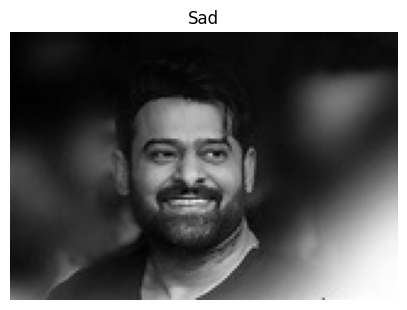

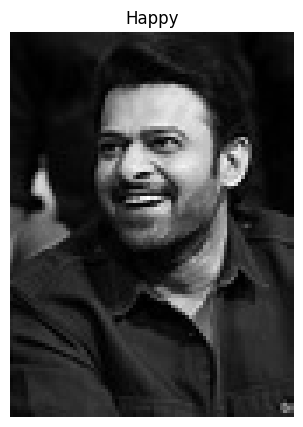

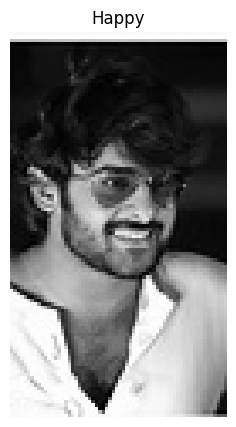

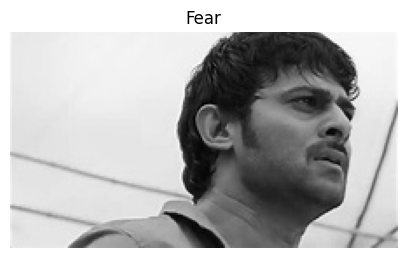

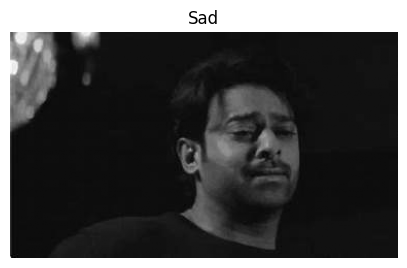

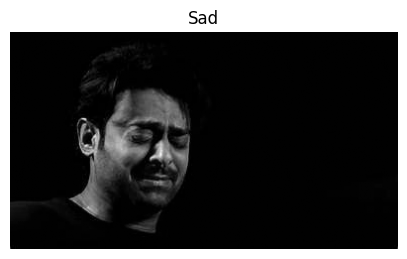

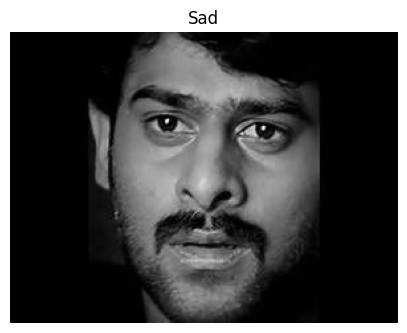

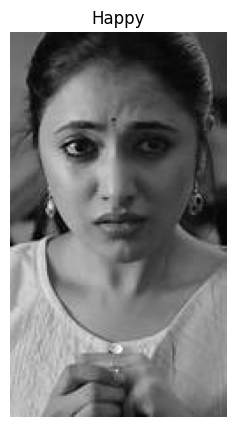

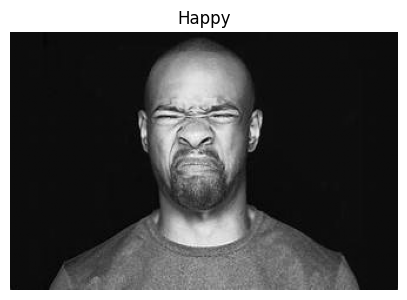

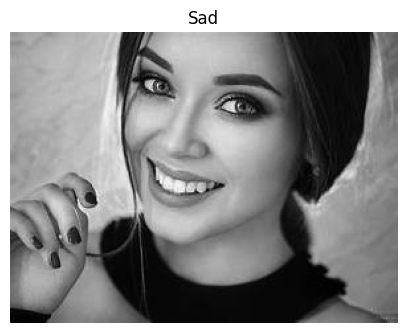

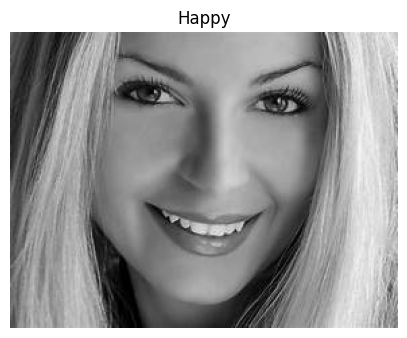

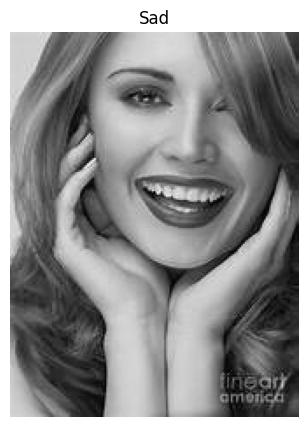

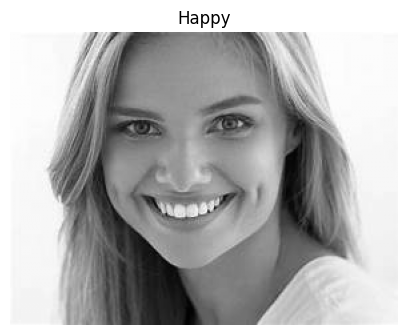

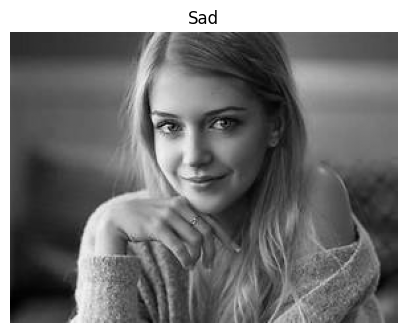

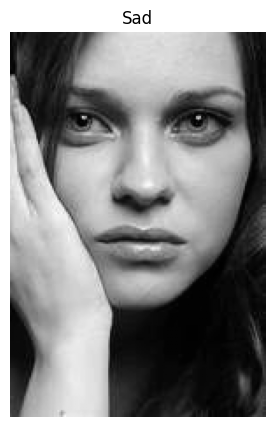

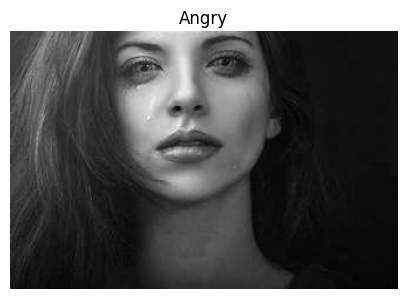

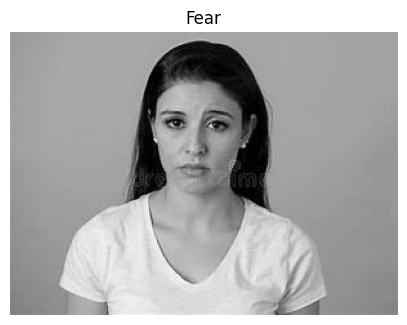

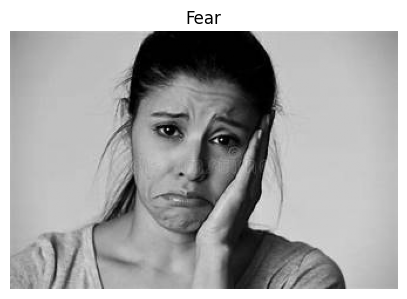

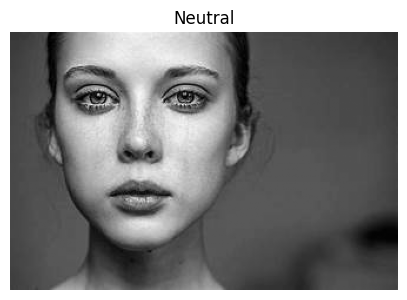

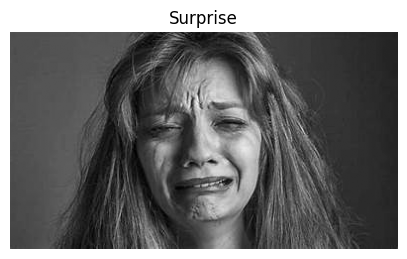

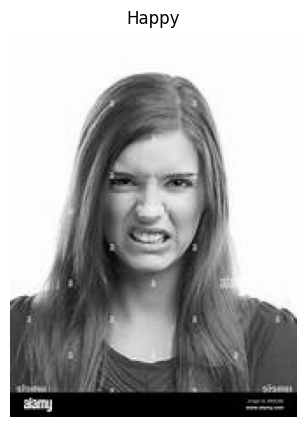

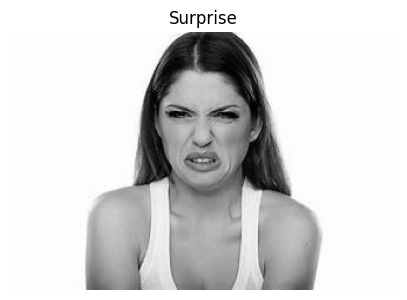

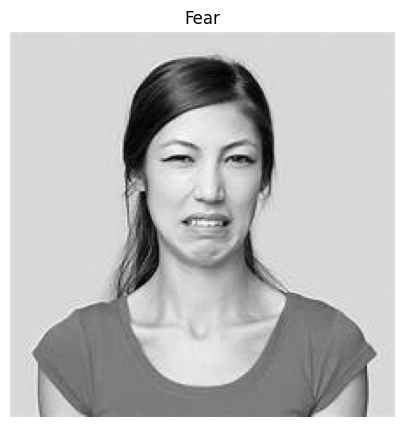

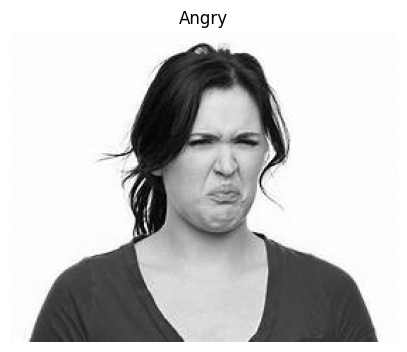

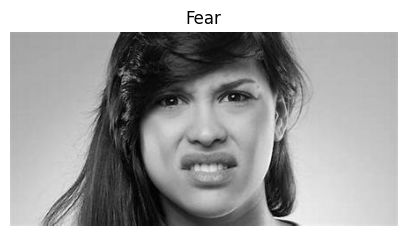

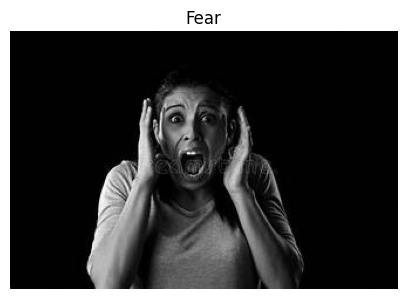

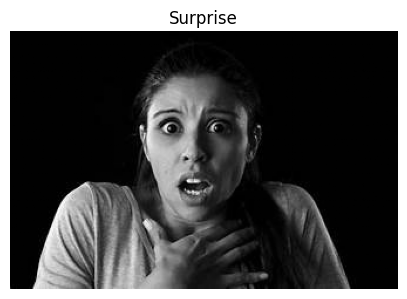

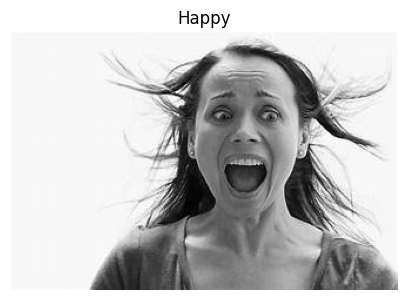

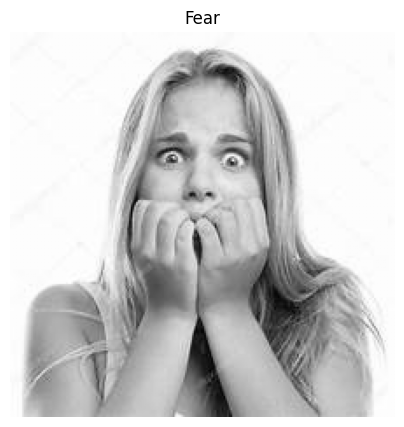

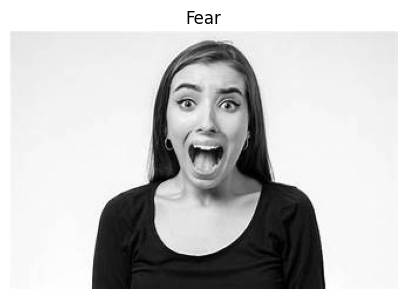

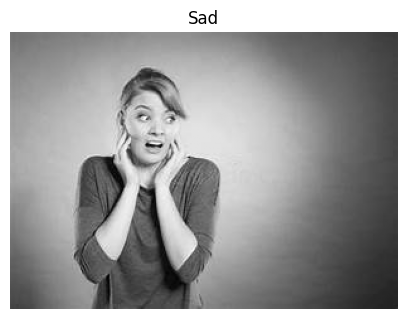

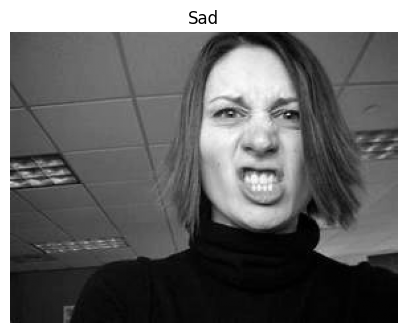

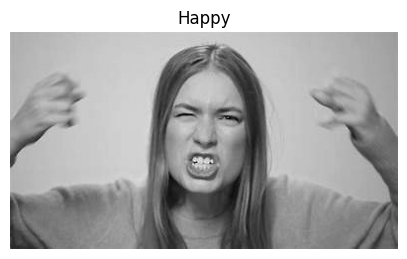

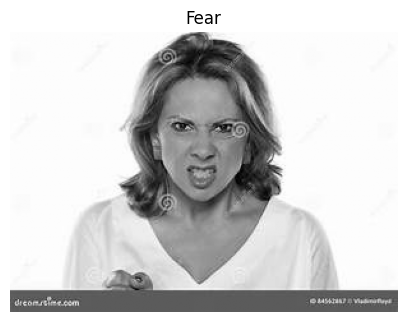

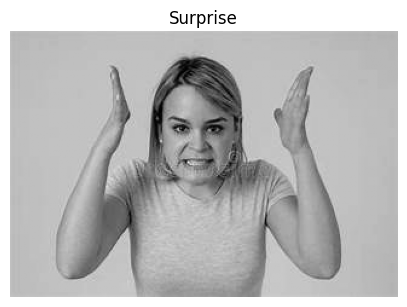

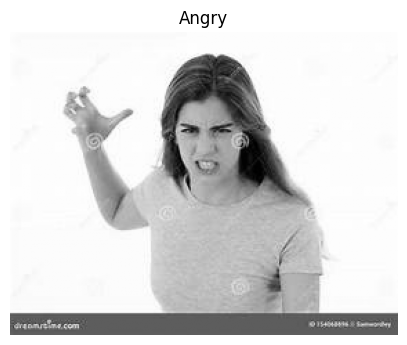

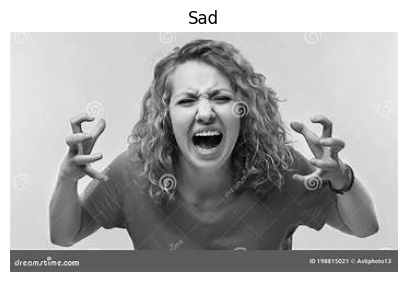

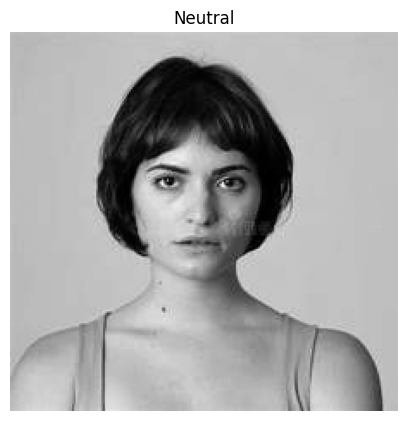

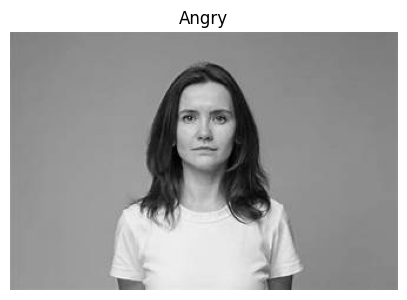

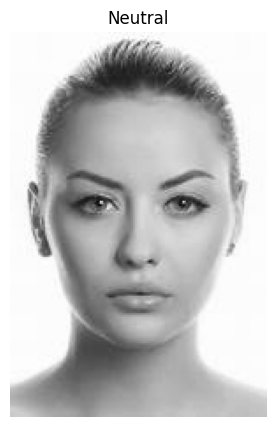

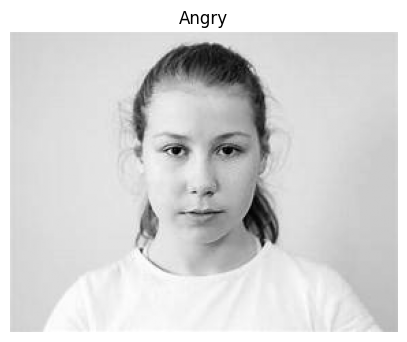

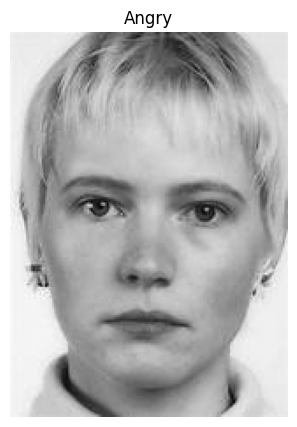

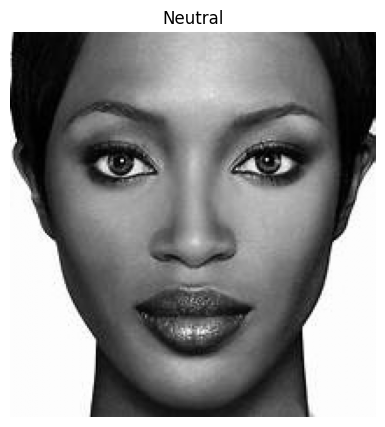

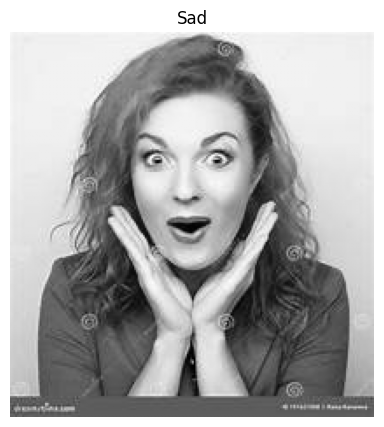

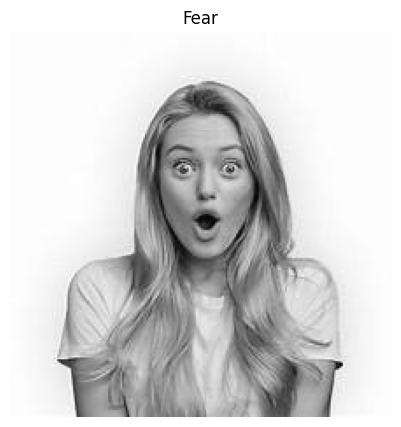

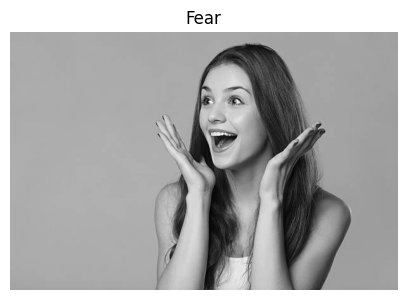

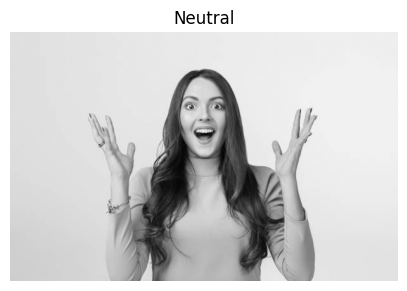

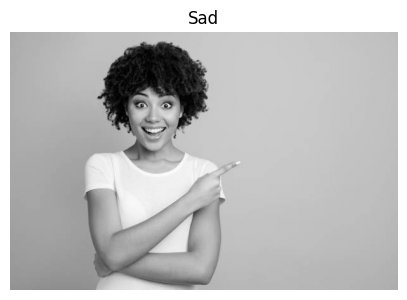

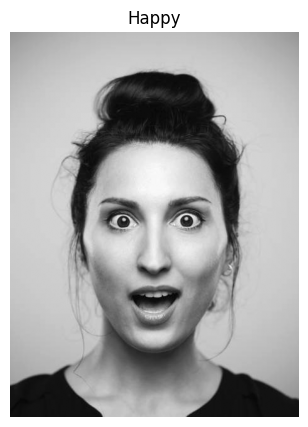

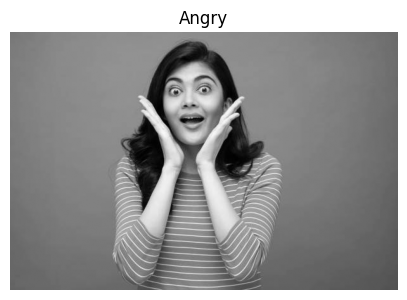

In [ ]:
MODEL_PATH = "best_model.pth"
PICS_FOLDER = "/content/drive/MyDrive/pics"

def get_transforms():
    return transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

def classify_images_in_folder(folder_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Deep_Emotion()
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

    transformation = get_transforms()
    classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert('L')
        image_tensor = transformation(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(F.softmax(output, dim=1), 1).item()
            prediction = classes[predicted_class]

        plt.figure(figsize=(5, 5))
        plt.imshow(image, cmap='gray')
        plt.title(prediction)
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    classify_images_in_folder(PICS_FOLDER)
